/opt/anaconda3/envs/qiskit-stable/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/qiskit-stable/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Aplicando Flip en el eje X...
Error cuadrático medio (MSE): 3871.491186522096


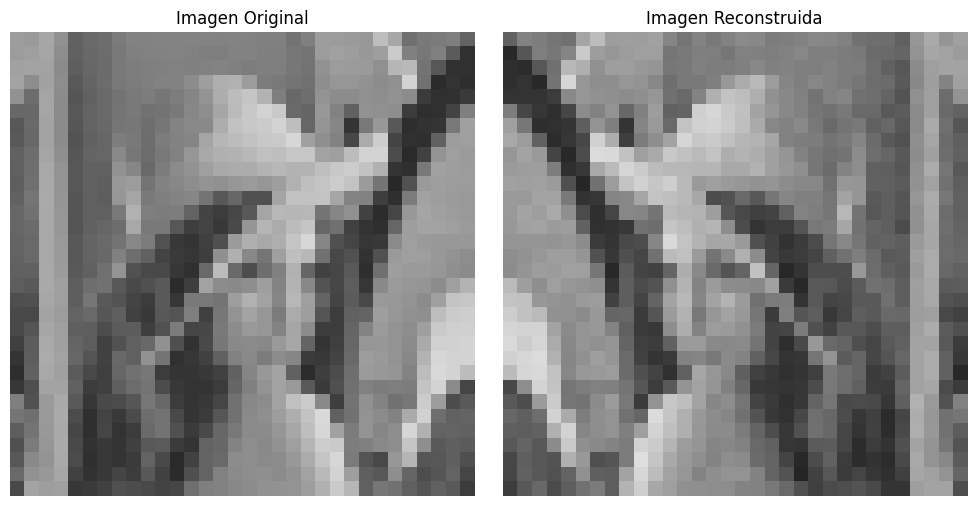

In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from qiskit.circuit.library import MCXGate


class FRQIEncoder:
    def __init__(self, image_path):
        self.image_path = image_path
        self.qubits = 12
        self.qc = QuantumCircuit(self.qubits, self.qubits)
        self.backend_sim = AerSimulator()  # Usamos AerSimulator aquí

    def image_normalization(self):
        image = Image.open(self.image_path).convert('LA')
        image = image.resize((32, 32))  # Redimensionar a 32x32
        image_array = np.array(image)[:, :, 0] / 255.0  # Escala de grises y normalización
        return np.arcsin(image_array.flatten())  # Normalización [0, π/2]

    def apply_hadamard(self):
        self.qc.h(range(2, self.qubits))  # Aplicar Hadamard a qubits 2 a 11

    def apply_frqi_encoding(self, pixel_data):
        for i, pixel in enumerate(pixel_data):
            if pixel != 0:
                self.c10mary(2 * pixel, format(i, '010b'), 0, 1, list(range(2, 12)))

    def c10mary(self, angle, bin_val, target, anc, controls):
        clist = [int(i) for i in bin_val]
        # Aplicar compuertas de control X cuando clist[i] es 0
        for i in range(len(clist)):
            if clist[i] == 0:
                self.qc.x(controls[-i-1])

        self.qc.mcry(angle, controls, target, anc)  # Rotación multicontrolada
        for i in range(len(clist)):
            if clist[i] == 0:
                self.qc.x(controls[-i-1])

    def quantum_flip(self, axis):
        """
        Realiza una inversión cuántica (flip) en el eje especificado.
        :param axis: 'x' para flip en el eje X, 'y' para flip en el eje Y
        """
        if axis == 'x':
            for qubit in range(2, 7):  # Qubits que codifican la posición en Y
                self.qc.x(qubit)
        elif axis == 'y':
            for qubit in range(7, 12):  # Qubits que codifican la posición en X
                self.qc.x(qubit)
        else:
            raise ValueError("El eje debe ser 'x' o 'y'")

    def coordinate_swap(self):
        """Intercambia las coordenadas X e Y mediante puertas SWAP"""
        for i in range(5):
            self.qc.swap(2 + i, 7 + i)

    def orthogonal_rotation(self, angle):
        """Aplica una rotación ortogonal a la imagen cuántica.
        :param angle: 90, 180 o 270 grados
        """
        if angle == 90:
            self.coordinate_swap()
            self.quantum_flip('x')
        elif angle == 180:
            self.quantum_flip('x')
            self.quantum_flip('y')
        elif angle == 270:
            self.coordinate_swap()
            self.quantum_flip('y')
        else:
            raise ValueError("El ángulo debe ser 90, 180 o 270 grados")

    def position_shift(self, direction, steps):
        """
        Realiza un desplazamiento de la imagen en una dirección específica.
        :param direction: 'x' o 'y'
        :param steps: número de posiciones para desplazar
        """
        if direction not in ['x', 'y']:
            raise ValueError("La dirección debe ser 'x' o 'y'")

        # Determina los qubits para la coordenada
        coord_qubits = list(range(7, 12)) if direction == 'x' else list(range(2, 7))
        
        for _ in range(steps):
            for i in range(len(coord_qubits)):
                # Configurar qubits de control y objetivo
                controls = coord_qubits[:i]
                target = coord_qubits[i]
                
                if len(controls) > 0:  # Solo aplica compuerta si hay controles
                    # Aplicar CkNOT, usando ancillas si es necesario
                    if len(controls) > 2:  # Más de 2 controles requiere ancillas
                        ancilla_qubits = [self.qc.qubits[-1]]  # Último qubit como ancilla
                        self.qc.mcx(controls, target, ancilla_qubits, mode='recursion')
                    else:
                        self.qc.mcx(controls, target)
                else:
                    self.qc.x(target)  # Si no hay controles, aplicar X directamente

    def run_simulation(self):
        self.qc.measure(range(self.qubits), range(self.qubits))
        transpiled_circuit = transpile(self.qc, self.backend_sim)
        result = self.backend_sim.run(transpiled_circuit, shots=1000000).result()
        return result.get_counts(self.qc)

    def reconstruct_image(self, counts, pixel_data_length):
        genimg = np.zeros(pixel_data_length)
        for i in range(pixel_data_length):
            try:
                genimg[i] = np.sqrt(counts[format(i, '010b') + '01'] / 1000000)
            except KeyError:
                pass
        return genimg * 32.0 * 255.0

    def calculate_mse(self, original, reconstructed):
        return mean_squared_error(original.flatten(), reconstructed.flatten())

    def save_images(self, original, reconstructed):
        np.savetxt('imagen_original.txt', original.reshape(32, 32), fmt='%d')
        np.savetxt('imagen_generada.txt', reconstructed.reshape(32, 32), fmt='%d')

    def show_images(self, original, reconstructed):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original.reshape(32, 32), cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Imagen Original')
        axes[0].axis('off')
        
        axes[1].imshow(reconstructed.reshape(32, 32), cmap='gray', vmin=0, vmax=255)
        axes[1].set_title('Imagen Reconstruida')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig('Comparacion_Imagenes.png')
        plt.show()

    # Función para dibujar el circuito cuántico como texto y guardarlo en un archivo txt
    def draw_circuit_text(self, filename='circuito_32x32.txt'):
        with open(filename, 'w') as f:
            text_circuit = self.qc.draw(output='text')
            f.write(str(text_circuit))

    def run(self, flip_axis=None, rotation=None, shift=None, apply_swap=False):
        pixel_data = self.image_normalization()
        self.apply_hadamard()
        self.apply_frqi_encoding(pixel_data)

        if flip_axis:
            print(f"Aplicando Flip en el eje {flip_axis.upper()}...")
            self.quantum_flip(flip_axis)
        
        if rotation:
            print(f"Aplicando Rotación Ortogonal de {rotation} grados...")
            self.orthogonal_rotation(rotation)
        
        if apply_swap:
            print("Aplicando Swap (intercambio de coordenadas X e Y)...")
            self.coordinate_swap()
        
        if shift:
            direction, steps = shift
            print(f"Aplicando Desplazamiento en la dirección {direction.upper()} por {steps} pasos...")
            self.position_shift(direction, steps)

        counts = self.run_simulation()

        genimg = self.reconstruct_image(counts, len(pixel_data))
        original_img = np.sin(pixel_data) * 255.0

        mse = self.calculate_mse(original_img, genimg)
        print(f'Error cuadrático medio (MSE): {mse}')

        self.save_images(original_img, genimg)
        self.show_images(original_img, genimg)
        self.draw_circuit_text()  # Guardar el circuito como texto

# Ejecución del código optimizado
if __name__ == '__main__':
    frqi_encoder = FRQIEncoder('img/lena.png')
    frqi_encoder.run(flip_axis='x')  


/opt/anaconda3/envs/qiskit-stable/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/qiskit-stable/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Aplicando Rotación Ortogonal de 90 grados...
Error cuadrático medio (MSE): 3988.0092719470913


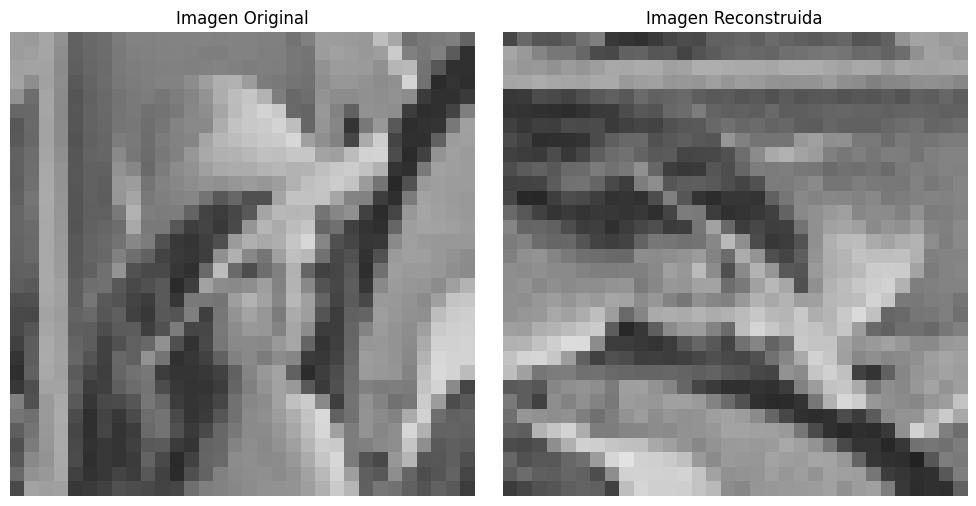

In [16]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from qiskit.circuit.library import MCXGate


class FRQIEncoder:
    def __init__(self, image_path):
        self.image_path = image_path
        self.qubits = 12
        self.qc = QuantumCircuit(self.qubits, self.qubits)
        self.backend_sim = AerSimulator()  # Usamos AerSimulator aquí

    def image_normalization(self):
        image = Image.open(self.image_path).convert('LA')
        image = image.resize((32, 32))  # Redimensionar a 32x32
        image_array = np.array(image)[:, :, 0] / 255.0  # Escala de grises y normalización
        return np.arcsin(image_array.flatten())  # Normalización [0, π/2]

    def apply_hadamard(self):
        self.qc.h(range(2, self.qubits))  # Aplicar Hadamard a qubits 2 a 11

    def apply_frqi_encoding(self, pixel_data):
        for i, pixel in enumerate(pixel_data):
            if pixel != 0:
                self.c10mary(2 * pixel, format(i, '010b'), 0, 1, list(range(2, 12)))

    def c10mary(self, angle, bin_val, target, anc, controls):
        clist = [int(i) for i in bin_val]
        # Aplicar compuertas de control X cuando clist[i] es 0
        for i in range(len(clist)):
            if clist[i] == 0:
                self.qc.x(controls[-i-1])

        self.qc.mcry(angle, controls, target, anc)  # Rotación multicontrolada
        for i in range(len(clist)):
            if clist[i] == 0:
                self.qc.x(controls[-i-1])

    def quantum_flip(self, axis):
        """
        Realiza una inversión cuántica (flip) en el eje especificado.
        :param axis: 'x' para flip en el eje X, 'y' para flip en el eje Y
        """
        if axis == 'x':
            for qubit in range(2, 7):  # Qubits que codifican la posición en Y
                self.qc.x(qubit)
        elif axis == 'y':
            for qubit in range(7, 12):  # Qubits que codifican la posición en X
                self.qc.x(qubit)
        else:
            raise ValueError("El eje debe ser 'x' o 'y'")

    def coordinate_swap(self):
        """Intercambia las coordenadas X e Y mediante puertas SWAP"""
        for i in range(5):
            self.qc.swap(2 + i, 7 + i)

    def orthogonal_rotation(self, angle):
        """Aplica una rotación ortogonal a la imagen cuántica.
        :param angle: 90, 180 o 270 grados
        """
        if angle == 90:
            self.coordinate_swap()
            self.quantum_flip('x')
        elif angle == 180:
            self.quantum_flip('x')
            self.quantum_flip('y')
        elif angle == 270:
            self.coordinate_swap()
            self.quantum_flip('y')
        else:
            raise ValueError("El ángulo debe ser 90, 180 o 270 grados")

    def position_shift(self, direction, steps):
        """
        Realiza un desplazamiento de la imagen en una dirección específica.
        :param direction: 'x' o 'y'
        :param steps: número de posiciones para desplazar
        """
        if direction not in ['x', 'y']:
            raise ValueError("La dirección debe ser 'x' o 'y'")

        # Determina los qubits para la coordenada
        coord_qubits = list(range(7, 12)) if direction == 'x' else list(range(2, 7))
        
        for _ in range(steps):
            for i in range(len(coord_qubits)):
                # Configurar qubits de control y objetivo
                controls = coord_qubits[:i]
                target = coord_qubits[i]
                
                if len(controls) > 0:  # Solo aplica compuerta si hay controles
                    # Aplicar CkNOT, usando ancillas si es necesario
                    if len(controls) > 2:  # Más de 2 controles requiere ancillas
                        ancilla_qubits = [self.qc.qubits[-1]]  # Último qubit como ancilla
                        self.qc.mcx(controls, target, ancilla_qubits, mode='recursion')
                    else:
                        self.qc.mcx(controls, target)
                else:
                    self.qc.x(target)  # Si no hay controles, aplicar X directamente

    def run_simulation(self):
        self.qc.measure(range(self.qubits), range(self.qubits))
        transpiled_circuit = transpile(self.qc, self.backend_sim)
        result = self.backend_sim.run(transpiled_circuit, shots=1000000).result()
        return result.get_counts(self.qc)

    def reconstruct_image(self, counts, pixel_data_length):
        genimg = np.zeros(pixel_data_length)
        for i in range(pixel_data_length):
            try:
                genimg[i] = np.sqrt(counts[format(i, '010b') + '01'] / 1000000)
            except KeyError:
                pass
        return genimg * 32.0 * 255.0

    def calculate_mse(self, original, reconstructed):
        return mean_squared_error(original.flatten(), reconstructed.flatten())

    def save_images(self, original, reconstructed):
        np.savetxt('imagen_original.txt', original.reshape(32, 32), fmt='%d')
        np.savetxt('imagen_generada.txt', reconstructed.reshape(32, 32), fmt='%d')

    def show_images(self, original, reconstructed):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original.reshape(32, 32), cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Imagen Original')
        axes[0].axis('off')
        
        axes[1].imshow(reconstructed.reshape(32, 32), cmap='gray', vmin=0, vmax=255)
        axes[1].set_title('Imagen Reconstruida')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig('Comparacion_Imagenes.png')
        plt.show()

    # Función para dibujar el circuito cuántico como texto y guardarlo en un archivo txt
    def draw_circuit_text(self, filename='circuito_32x32.txt'):
        with open(filename, 'w') as f:
            text_circuit = self.qc.draw(output='text')
            f.write(str(text_circuit))

    def run(self, flip_axis=None, rotation=None, shift=None, apply_swap=False):
        pixel_data = self.image_normalization()
        self.apply_hadamard()
        self.apply_frqi_encoding(pixel_data)

        if flip_axis:
            print(f"Aplicando Flip en el eje {flip_axis.upper()}...")
            self.quantum_flip(flip_axis)
        
        if rotation:
            print(f"Aplicando Rotación Ortogonal de {rotation} grados...")
            self.orthogonal_rotation(rotation)
        
        if apply_swap:
            print("Aplicando Swap (intercambio de coordenadas X e Y)...")
            self.coordinate_swap()
        
        if shift:
            direction, steps = shift
            print(f"Aplicando Desplazamiento en la dirección {direction.upper()} por {steps} pasos...")
            self.position_shift(direction, steps)

        counts = self.run_simulation()

        genimg = self.reconstruct_image(counts, len(pixel_data))
        original_img = np.sin(pixel_data) * 255.0

        mse = self.calculate_mse(original_img, genimg)
        print(f'Error cuadrático medio (MSE): {mse}')

        self.save_images(original_img, genimg)
        self.show_images(original_img, genimg)
        self.draw_circuit_text()  # Guardar el circuito como texto

# Ejecución del código optimizado
if __name__ == '__main__':
    frqi_encoder = FRQIEncoder('img/lena.png')
    frqi_encoder.run( rotation=90, )  


/opt/anaconda3/envs/qiskit-stable/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/qiskit-stable/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Aplicando Desplazamiento en la dirección Y por 5 pasos...
Error cuadrático medio (MSE): 3519.4837465295877


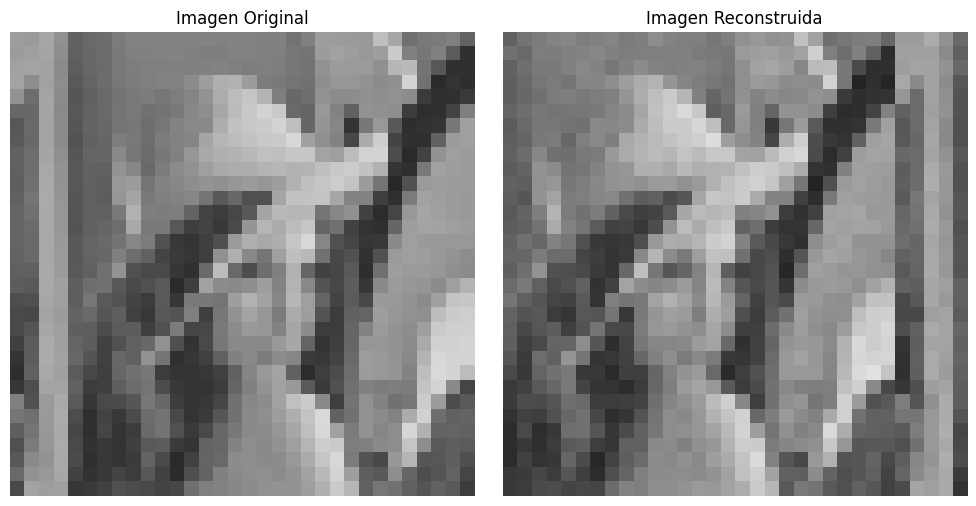

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from qiskit.circuit.library import MCXGate


class FRQIEncoder:
    def __init__(self, image_path):
        self.image_path = image_path
        self.qubits = 12
        self.qc = QuantumCircuit(self.qubits, self.qubits)
        self.backend_sim = AerSimulator()  # Usamos AerSimulator aquí

    def image_normalization(self):
        image = Image.open(self.image_path).convert('LA')
        image = image.resize((32, 32))  # Redimensionar a 32x32
        image_array = np.array(image)[:, :, 0] / 255.0  # Escala de grises y normalización
        return np.arcsin(image_array.flatten())  # Normalización [0, π/2]

    def apply_hadamard(self):
        self.qc.h(range(2, self.qubits))  # Aplicar Hadamard a qubits 2 a 11

    def apply_frqi_encoding(self, pixel_data):
        for i, pixel in enumerate(pixel_data):
            if pixel != 0:
                self.c10mary(2 * pixel, format(i, '010b'), 0, 1, list(range(2, 12)))

    def c10mary(self, angle, bin_val, target, anc, controls):
        clist = [int(i) for i in bin_val]
        # Aplicar compuertas de control X cuando clist[i] es 0
        for i in range(len(clist)):
            if clist[i] == 0:
                self.qc.x(controls[-i-1])

        self.qc.mcry(angle, controls, target, anc)  # Rotación multicontrolada
        for i in range(len(clist)):
            if clist[i] == 0:
                self.qc.x(controls[-i-1])

    def quantum_flip(self, axis):
        """
        Realiza una inversión cuántica (flip) en el eje especificado.
        :param axis: 'x' para flip en el eje X, 'y' para flip en el eje Y
        """
        if axis == 'x':
            for qubit in range(2, 7):  # Qubits que codifican la posición en Y
                self.qc.x(qubit)
        elif axis == 'y':
            for qubit in range(7, 12):  # Qubits que codifican la posición en X
                self.qc.x(qubit)
        else:
            raise ValueError("El eje debe ser 'x' o 'y'")

    def coordinate_swap(self):
        """Intercambia las coordenadas X e Y mediante puertas SWAP"""
        for i in range(5):
            self.qc.swap(2 + i, 7 + i)

    def orthogonal_rotation(self, angle):
        """Aplica una rotación ortogonal a la imagen cuántica.
        :param angle: 90, 180 o 270 grados
        """
        if angle == 90:
            self.coordinate_swap()
            self.quantum_flip('x')
        elif angle == 180:
            self.quantum_flip('x')
            self.quantum_flip('y')
        elif angle == 270:
            self.coordinate_swap()
            self.quantum_flip('y')
        else:
            raise ValueError("El ángulo debe ser 90, 180 o 270 grados")

    def position_shift(self, direction, steps):
        """
        Realiza un desplazamiento de la imagen en una dirección específica.
        :param direction: 'x' o 'y'
        :param steps: número de posiciones para desplazar
        """
        if direction not in ['x', 'y']:
            raise ValueError("La dirección debe ser 'x' o 'y'")

        # Determina los qubits para la coordenada
        coord_qubits = list(range(7, 12)) if direction == 'x' else list(range(2, 7))
        
        for _ in range(steps):
            for i in range(len(coord_qubits)):
                # Configurar qubits de control y objetivo
                controls = coord_qubits[:i]
                target = coord_qubits[i]
                
                if len(controls) > 0:  # Solo aplica compuerta si hay controles
                    # Aplicar CkNOT, usando ancillas si es necesario
                    if len(controls) > 2:  # Más de 2 controles requiere ancillas
                        ancilla_qubits = [self.qc.qubits[-1]]  # Último qubit como ancilla
                        self.qc.mcx(controls, target, ancilla_qubits, mode='recursion')
                    else:
                        self.qc.mcx(controls, target)
                else:
                    self.qc.x(target)  # Si no hay controles, aplicar X directamente

    def run_simulation(self):
        self.qc.measure(range(self.qubits), range(self.qubits))
        transpiled_circuit = transpile(self.qc, self.backend_sim)
        result = self.backend_sim.run(transpiled_circuit, shots=1000000).result()
        return result.get_counts(self.qc)

    def reconstruct_image(self, counts, pixel_data_length):
        genimg = np.zeros(pixel_data_length)
        for i in range(pixel_data_length):
            try:
                genimg[i] = np.sqrt(counts[format(i, '010b') + '01'] / 1000000)
            except KeyError:
                pass
        return genimg * 32.0 * 255.0

    def calculate_mse(self, original, reconstructed):
        return mean_squared_error(original.flatten(), reconstructed.flatten())

    def save_images(self, original, reconstructed):
        np.savetxt('imagen_original.txt', original.reshape(32, 32), fmt='%d')
        np.savetxt('imagen_generada.txt', reconstructed.reshape(32, 32), fmt='%d')

    def show_images(self, original, reconstructed):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original.reshape(32, 32), cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Imagen Original')
        axes[0].axis('off')
        
        axes[1].imshow(reconstructed.reshape(32, 32), cmap='gray', vmin=0, vmax=255)
        axes[1].set_title('Imagen Reconstruida')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig('Comparacion_Imagenes.png')
        plt.show()

    # Función para dibujar el circuito cuántico como texto y guardarlo en un archivo txt
    def draw_circuit_text(self, filename='circuito_32x32.txt'):
        with open(filename, 'w') as f:
            text_circuit = self.qc.draw(output='text')
            f.write(str(text_circuit))

    def run(self, flip_axis=None, rotation=None, shift=None, apply_swap=False):
        pixel_data = self.image_normalization()
        self.apply_hadamard()
        self.apply_frqi_encoding(pixel_data)

        if flip_axis:
            print(f"Aplicando Flip en el eje {flip_axis.upper()}...")
            self.quantum_flip(flip_axis)
        
        if rotation:
            print(f"Aplicando Rotación Ortogonal de {rotation} grados...")
            self.orthogonal_rotation(rotation)
        
        if apply_swap:
            print("Aplicando Swap (intercambio de coordenadas X e Y)...")
            self.coordinate_swap()
        
        if shift:
            direction, steps = shift
            print(f"Aplicando Desplazamiento en la dirección {direction.upper()} por {steps} pasos...")
            self.position_shift(direction, steps)

        counts = self.run_simulation()

        genimg = self.reconstruct_image(counts, len(pixel_data))
        original_img = np.sin(pixel_data) * 255.0

        mse = self.calculate_mse(original_img, genimg)
        print(f'Error cuadrático medio (MSE): {mse}')

        self.save_images(original_img, genimg)
        self.show_images(original_img, genimg)
        self.draw_circuit_text()  # Guardar el circuito como texto

# Ejecución del código optimizado
if __name__ == '__main__':
    frqi_encoder = FRQIEncoder('img/lena.png')
    frqi_encoder.run(shift=('y', 5))  # Ejemplo de uso


/opt/anaconda3/envs/qiskit-stable/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/qiskit-stable/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Aplicando Swap (intercambio de coordenadas X e Y)...
Error cuadrático medio (MSE): 3066.4328953531613


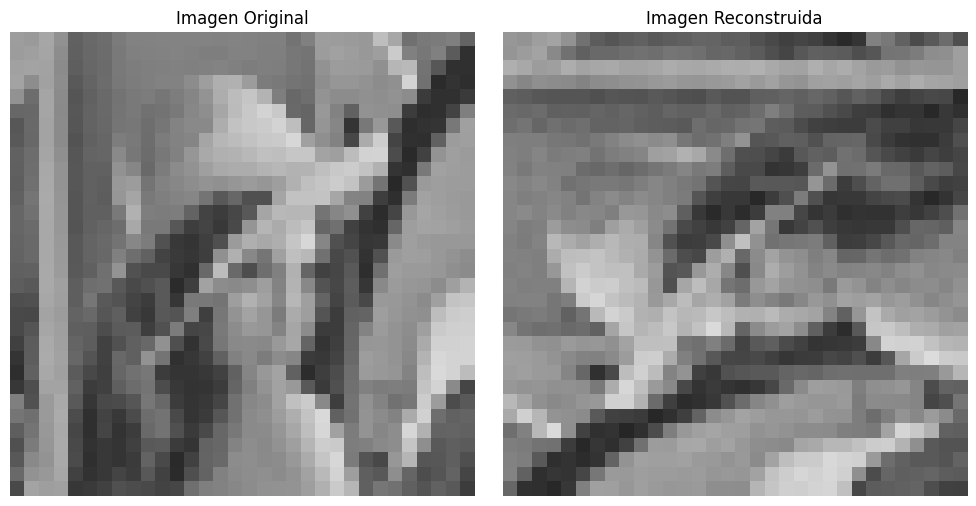

In [19]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from qiskit.circuit.library import MCXGate


class FRQIEncoder:
    def __init__(self, image_path):
        self.image_path = image_path
        self.qubits = 12
        self.qc = QuantumCircuit(self.qubits, self.qubits)
        self.backend_sim = AerSimulator()  # Usamos AerSimulator aquí

    def image_normalization(self):
        image = Image.open(self.image_path).convert('LA')
        image = image.resize((32, 32))  # Redimensionar a 32x32
        image_array = np.array(image)[:, :, 0] / 255.0  # Escala de grises y normalización
        return np.arcsin(image_array.flatten())  # Normalización [0, π/2]

    def apply_hadamard(self):
        self.qc.h(range(2, self.qubits))  # Aplicar Hadamard a qubits 2 a 11

    def apply_frqi_encoding(self, pixel_data):
        for i, pixel in enumerate(pixel_data):
            if pixel != 0:
                self.c10mary(2 * pixel, format(i, '010b'), 0, 1, list(range(2, 12)))

    def c10mary(self, angle, bin_val, target, anc, controls):
        clist = [int(i) for i in bin_val]
        # Aplicar compuertas de control X cuando clist[i] es 0
        for i in range(len(clist)):
            if clist[i] == 0:
                self.qc.x(controls[-i-1])

        self.qc.mcry(angle, controls, target, anc)  # Rotación multicontrolada
        for i in range(len(clist)):
            if clist[i] == 0:
                self.qc.x(controls[-i-1])

    def quantum_flip(self, axis):
        """
        Realiza una inversión cuántica (flip) en el eje especificado.
        :param axis: 'x' para flip en el eje X, 'y' para flip en el eje Y
        """
        if axis == 'x':
            for qubit in range(2, 7):  # Qubits que codifican la posición en Y
                self.qc.x(qubit)
        elif axis == 'y':
            for qubit in range(7, 12):  # Qubits que codifican la posición en X
                self.qc.x(qubit)
        else:
            raise ValueError("El eje debe ser 'x' o 'y'")

    def coordinate_swap(self):
        """Intercambia las coordenadas X e Y mediante puertas SWAP"""
        for i in range(5):
            self.qc.swap(2 + i, 7 + i)

    def orthogonal_rotation(self, angle):
        """Aplica una rotación ortogonal a la imagen cuántica.
        :param angle: 90, 180 o 270 grados
        """
        if angle == 90:
            self.coordinate_swap()
            self.quantum_flip('x')
        elif angle == 180:
            self.quantum_flip('x')
            self.quantum_flip('y')
        elif angle == 270:
            self.coordinate_swap()
            self.quantum_flip('y')
        else:
            raise ValueError("El ángulo debe ser 90, 180 o 270 grados")

    def position_shift(self, direction, steps):
        """
        Realiza un desplazamiento de la imagen en una dirección específica.
        :param direction: 'x' o 'y'
        :param steps: número de posiciones para desplazar
        """
        if direction not in ['x', 'y']:
            raise ValueError("La dirección debe ser 'x' o 'y'")

        # Determina los qubits para la coordenada
        coord_qubits = list(range(7, 12)) if direction == 'x' else list(range(2, 7))
        
        for _ in range(steps):
            for i in range(len(coord_qubits)):
                # Configurar qubits de control y objetivo
                controls = coord_qubits[:i]
                target = coord_qubits[i]
                
                if len(controls) > 0:  # Solo aplica compuerta si hay controles
                    # Aplicar CkNOT, usando ancillas si es necesario
                    if len(controls) > 2:  # Más de 2 controles requiere ancillas
                        ancilla_qubits = [self.qc.qubits[-1]]  # Último qubit como ancilla
                        self.qc.mcx(controls, target, ancilla_qubits, mode='recursion')
                    else:
                        self.qc.mcx(controls, target)
                else:
                    self.qc.x(target)  # Si no hay controles, aplicar X directamente

    def run_simulation(self):
        self.qc.measure(range(self.qubits), range(self.qubits))
        transpiled_circuit = transpile(self.qc, self.backend_sim)
        result = self.backend_sim.run(transpiled_circuit, shots=1000000).result()
        return result.get_counts(self.qc)

    def reconstruct_image(self, counts, pixel_data_length):
        genimg = np.zeros(pixel_data_length)
        for i in range(pixel_data_length):
            try:
                genimg[i] = np.sqrt(counts[format(i, '010b') + '01'] / 1000000)
            except KeyError:
                pass
        return genimg * 32.0 * 255.0

    def calculate_mse(self, original, reconstructed):
        return mean_squared_error(original.flatten(), reconstructed.flatten())

    def save_images(self, original, reconstructed):
        np.savetxt('imagen_original.txt', original.reshape(32, 32), fmt='%d')
        np.savetxt('imagen_generada.txt', reconstructed.reshape(32, 32), fmt='%d')

    def show_images(self, original, reconstructed):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original.reshape(32, 32), cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Imagen Original')
        axes[0].axis('off')
        
        axes[1].imshow(reconstructed.reshape(32, 32), cmap='gray', vmin=0, vmax=255)
        axes[1].set_title('Imagen Reconstruida')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig('Comparacion_Imagenes.png')
        plt.show()

    # Función para dibujar el circuito cuántico como texto y guardarlo en un archivo txt
    def draw_circuit_text(self, filename='circuito_32x32.txt'):
        with open(filename, 'w') as f:
            text_circuit = self.qc.draw(output='text')
            f.write(str(text_circuit))

    def run(self, flip_axis=None, rotation=None, shift=None, apply_swap=False):
        pixel_data = self.image_normalization()
        self.apply_hadamard()
        self.apply_frqi_encoding(pixel_data)

        if flip_axis:
            print(f"Aplicando Flip en el eje {flip_axis.upper()}...")
            self.quantum_flip(flip_axis)
        
        if rotation:
            print(f"Aplicando Rotación Ortogonal de {rotation} grados...")
            self.orthogonal_rotation(rotation)
        
        if apply_swap:
            print("Aplicando Swap (intercambio de coordenadas X e Y)...")
            self.coordinate_swap()
        
        if shift:
            direction, steps = shift
            print(f"Aplicando Desplazamiento en la dirección {direction.upper()} por {steps} pasos...")
            self.position_shift(direction, steps)

        counts = self.run_simulation()

        genimg = self.reconstruct_image(counts, len(pixel_data))
        original_img = np.sin(pixel_data) * 255.0

        mse = self.calculate_mse(original_img, genimg)
        print(f'Error cuadrático medio (MSE): {mse}')

        self.save_images(original_img, genimg)
        self.show_images(original_img, genimg)
        self.draw_circuit_text()  # Guardar el circuito como texto

# Ejecución del código optimizado
if __name__ == '__main__':
    frqi_encoder = FRQIEncoder('img/lena.png')
    frqi_encoder.run( apply_swap=True)  
